# Calculating slope and aspect from a digital elevation model in Python

Author: Matt Oakley

Digital elevation models (DEM) provide a representaion of surface topography (elevation) in two dimensional space. DEMs are a 3D representaion of a terrain's surface such as the Earth. Typically, DEM data can be represented as a raster which is most easily expressed as being a 2D array with each individual cell having an elevation associated with it. 

With this data, we are able to use programs in order to analyze certain physical aspects about the area associated with the data. This tutorial will go over how we compute the **slope** and **aspect** of an area using DEM data.

## Objectives

- Read in DEM data
- Compute the slope for the entirety of the data
- Compute the aspect for the entirety of the data
- Output a PNG image visualizing the slope of the terrain
- Output a PNG image visualizing the aspect of the terrain

## Dependencies

- OGR/GDAL
- NumPy
- matplotlib

In [ ]:
!conda install gdal

In [1]:
from __future__ import division
from osgeo import gdal
from matplotlib.colors import ListedColormap
from matplotlib import colors
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Read in DEM Data

Our first objective is to read in the DEM data we've acquired. For this tutorial we'll be using DEM data of the Colorado Front Range area. We'll use gdal in order to open this file and NumPy to convert the raster object into a 2D NumPy array.

In [2]:
#Open the front_range.dem file using gdal
filename = '../data/front_range_dem.tif'

# define helper functions
def getResolution(rasterfn):
    raster = gdal.Open(rasterfn)
    geotransform = raster.GetGeoTransform()
    res = {"east-west": abs(geotransform[1]), 
           "north-south": abs(geotransform[5])}
    return res

# next 2 functions: https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html
def raster2array(rasterfn):
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    return band.ReadAsArray()

def getNoDataValue(rasterfn):
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    return band.GetNoDataValue()

# load raster as 2D numpy array
data_array = raster2array(filename)
nodataval = getNoDataValue(filename)
resolution = getResolution(filename)
print(resolution)

{'north-south': 1110.0, 'east-west': 854.0}


In [3]:
print(type(data_array))
print(data_array.shape)
print(nodataval)

<class 'numpy.ndarray'>
(220, 124)
-1.7e+308


## Computing Slope

Now that we've read in the DEM data and converted it to a 2D NumPy array, we're able to start doing computation on it. Our first goal is to compute the slope at each point in the 2D array. Many methods have been developed for computing slope, and here we follow Horn (1981). Assuming each cell has surrounding cells in the following manner:

    a | b | c
    ----------
    d | e | f 
    ----------
    g | h | q

Where 'e' is the current focal cell whose slope is to be calculated.
    
We can calculate the slope for that specific cell algorithmically via the following equations:
    
$$\dfrac{dz}{dx} = ((c + 2f + q) - (a + 2d + g)) / (8 r_x)$$

$$\dfrac{dz}{dy} = ((g + 2h + q) - (a + 2b + c)) / (8 r_y)$$

$$\dfrac{\text{rise}}{\text{run}} = \sqrt{\dfrac{dz}{dx}^2 + \dfrac{dz}{dy}^2}$$

$$\text{slope} = \text{atan}\Big(\frac{\text{rise}}{\text{run}} \times 57.29578\Big)$$

where $r_x$ and $r_y$ are the resolutions in the x and y directions.

## Computing Aspect

Now that we have a new array, slope_array, which has the slope values we computed for each cell, we can do the same thing but for aspect. We can do this very similarly to how we calculated slope but with a few minor tweaks in the algorithm used. Assuming each cell has the same structure as before, we can calculate the aspect for each individual cell via the following equations:

$$\text{aspect} = \text{atan2}\Big(\dfrac{dz}{dy}, -\dfrac{dz}{dx} \Big)$$


Algorithmically then:


    if aspect < 0:
        cell = 90 - aspect
    else if aspect > 90:
        cell = 360 - aspect + 90
    else:
        cell = 90 - aspect

In [4]:
num_rows = data_array.shape[0]
num_cols = data_array.shape[1]

# make all elements missing to start with
slope_array = np.ones_like(data_array) * nodataval
aspect_array = np.ones_like(data_array) * nodataval

In [5]:
# iterate over each cell in the 2D array (excluding edges)
for i in range(1, num_rows - 1):
    for j in range(1, num_cols - 1):
        a = data_array[i - 1][j - 1]
        b = data_array[i - 1][j]
        c = data_array[i - 1][j + 1]
        d = data_array[i][j - 1]
        e = data_array[i][j]
        f = data_array[i][j + 1]
        g = data_array[i + 1][j - 1]
        h = data_array[i + 1][j]
        q = data_array[i + 1][j + 1]
        
        vals = [a, b, c, d, e, f, g, h, q]
        
        if nodataval in vals:
            all_present = False
        else:
            all_present = True
                        
        if all_present == True:
            dz_dx = (c + (2 * f) + q - a - (2 * d) - g) / (8 * resolution['east-west'])
            dz_dy = (g + (2 * h) + q - a - (2 * b) - c) / (8 * resolution['north-south'])
            dz_dx_sq = math.pow(dz_dx, 2)
            dz_dy_sq = math.pow(dz_dy, 2)
            
            rise_run = math.sqrt(dz_dx_sq + dz_dy_sq)
            slope_array[i][j] = math.atan(rise_run) * 57.29578
            
            aspect = math.atan2(dz_dy, (-1 * dz_dx)) * 57.29578
            if aspect < 0:
                aspect_array[i][j] = 90 - aspect
            elif aspect > 90:
                aspect_array[i][j] = 360 - aspect + 90
            else:
                aspect_array[i][j] = 90 - aspect


## Visualizing Slope

We've now done all the computation that we need to do - time to see the results! In order to visualize slope, our algorithm stored the values (in degrees) of the slope at each individual cell. Therefore, we can easily visualize this via matplotlib by assigning color ranges to the values present (0 through 90). Let's do this by having values towards the bottom of our range have a green color and the progress to a red color as the values grow larger.

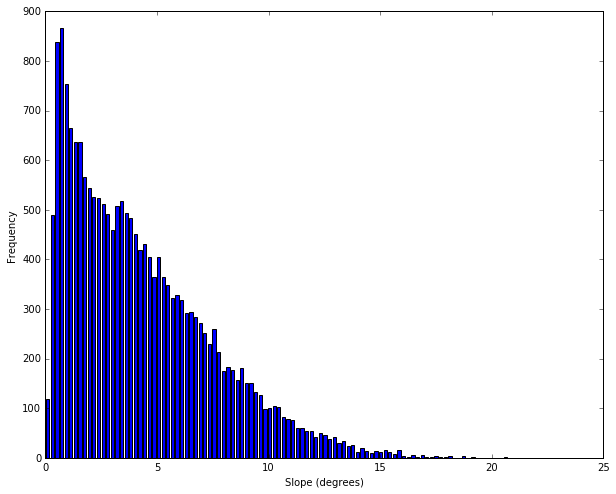

In [6]:
hist, bins = np.histogram(slope_array, bins=100, range=(0, np.amax(slope_array)))
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xlabel('Slope (degrees)')
plt.ylabel('Frequency')
plt.show()

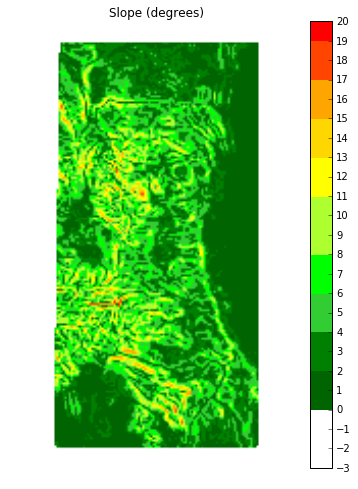

In [7]:
#Set up the colors and colorbar associated with the slope visualization
color_map = ListedColormap(['white', 'darkgreen', 'green', 'limegreen', 'lime', 
                            'greenyellow', 'yellow', 'gold', 
                            'orange', 'orangered', 'red'])

# range begins at negative value so that missing values are white
color_bounds = list(range(-3, math.ceil(np.amax(slope_array)), 1))
color_norm = colors.BoundaryNorm(color_bounds, color_map.N)

#Create the plot and colorbar
img = plt.imshow(slope_array, cmap = color_map, norm = color_norm)
cbar = plt.colorbar(img, cmap = color_map, norm = color_norm,
                   boundaries = color_bounds, ticks = color_bounds)

#Show the visualization
plt.axis('off')
plt.title("Slope (degrees)")
plt.show()
plt.close()

## Visualizing Aspect

This is the exact same process as visualizing slope but with a few minor tweaks in regards to our colors and colorbar. We calculated aspect so we can see the cardinal direction that each cell is facing. Therefore, we'll have to adjust our color scheme to show which color is associated with each cardinal direction.

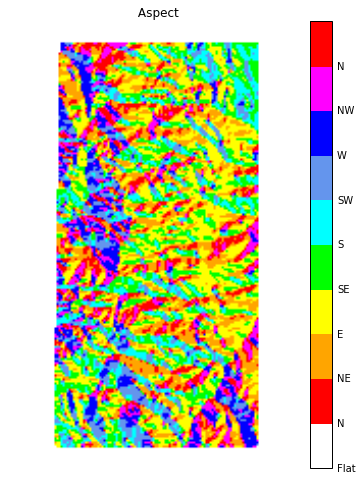

In [8]:
#Set up the colors and colorbar associated the aspect visualization
color_map = ListedColormap(['white', 'red', 'orange', 'yellow', 'lime', 'cyan',
                           'cornflowerblue', 'blue', 'magenta', 'red'])
color_bounds = [-1, 0, 22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5, 360]
color_norm = colors.BoundaryNorm(color_bounds, color_map.N)

#Create the plot and colorbar
img = plt.imshow(aspect_array, cmap = color_map, norm = color_norm)
cbar = plt.colorbar(img, cmap = color_map, norm = color_norm,
                   boundaries = color_bounds, ticks = color_bounds)
cbar.ax.tick_params(length = 0, pad = 5)
cbar.ax.set_yticklabels(['Flat', 'N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'])

#Show the visualization
plt.axis('off')
plt.title(" Aspect")
plt.show()
plt.close()